In [1]:
print('testing123')

testing123


In [2]:
import pandas as pd

df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
print(df.shape)
print(df.isnull().sum())

(50000, 2)
review       0
sentiment    0
dtype: int64


In [4]:
for sentence in df.review[:5]:
    print(sentence,'\n')

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [5]:
# download medium model
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB 1.3 MB/s eta 0:00:34
     --------------------------------------- 0.1/42.8 MB 518.5 kB/s eta 0:01:23
     --------------------------------------- 0.1/42.8 MB 930.9 kB/s eta 0:00:46
     ---------------------------------------- 0.2/42.8 MB 1.0 MB/s eta 0:00:41
     ---------------------------------------- 0.3/42.8 MB 1.1 MB/s eta 0:00:38
     ---------------------------------------- 0.4/42.8 MB 1.3 MB/s eta 0:00:32
     ---------------------------------------- 0.4/42.8 MB 1.3 MB/s eta 0:00:32
      --------------------------------------- 0.6/42.8 MB 1.8 MB/s eta 0:00:24
      --------------------------------------- 0.9/42.8 MB 2.1 MB/s eta 0:00:21
     - -------------------------------------- 1.2/42.8 MB 2.7 MB/s eta 0:00:16
     - -------------------------------------- 1.9/42.8 MB 3.7 MB/s eta 0:00:11
     -- ------------------------------------- 2.5/42.8 MB

In [6]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [7]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first')

In [8]:
result = ohe.fit_transform(df[['sentiment']]).toarray()
ohe.categories_

[array(['negative', 'positive'], dtype=object)]

In [9]:
df['sentiment'] = pd.DataFrame(result)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1.0
1,A wonderful little production. <br /><br />The...,1.0
2,I thought this was a wonderful way to spend ti...,1.0
3,Basically there's a family where a little boy ...,0.0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1.0


In [10]:
X = df['review']
y = df['sentiment']
X.shape, y.shape

((50000,), (50000,))

In [11]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=43,stratify=y)

X_train.shape,X_test.shape

((40000,), (10000,))

## Text cleaning Steps:
1. symbol,punctuations removal
2. stopwords removal
3. lemmatize


In [13]:
import string
import re
import spacy
print(spacy.__version__)

from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm

nlp = spacy.load('en_core_web_md')
punctuations = string.punctuation

cleaned_reviews = []
for text in tqdm(X_train['review']):
    #print(text)
    # Remove <br /> tags, emojis
    clean_text = re.sub('<br\s*/?>', '', text)
    clean_text = re.sub(':\S+', '', clean_text)

    doc = nlp(clean_text)
    # lemmatize -> remove stopwords and punctuations
    lemma_tokens = [token.lemma_ for token in doc if token.pos_ !='PRON']
    clean_tokens = ' '.join([token.lower() for token in lemma_tokens if token not in STOP_WORDS and token not in punctuations])
    cleaned_reviews.append(clean_tokens)
    #print(clean_tokens,'\n')

X_train['review'] = cleaned_reviews

3.7.4
3.7.4


100%|██████████| 40000/40000 [22:02<00:00, 30.25it/s]


#### with spacy, the processing time reduced by alot compared to nltk library
#### below picture show the previous approach and time consumed.
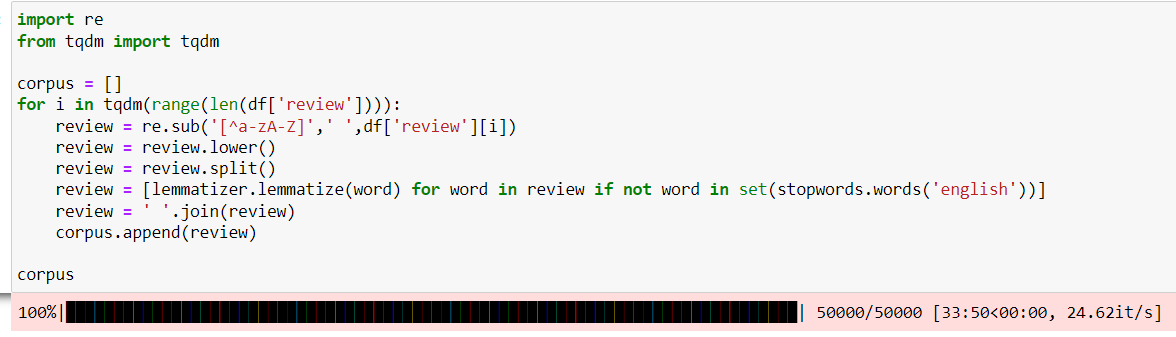

In [16]:
X_train.head()

,review
45657,think river soul good babylon 5 movie exceptio...
21120,earth surprising beautiful romantic tale saman...
40578,title reference destruction remnant harvest li...
49770,hedy lamarr man screen actress mistress kent t...
11504,guess remember nicole eggert little girl day t...


In [12]:
import string
import re
import spacy
print(spacy.__version__)

from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm

nlp = spacy.load('en_core_web_md')
punctuations = string.punctuation

def tokenizer(text):
    
    # Remove <br /> tags, emojis
    clean_text = re.sub('<br\s*/?>', '', text)
    clean_text = re.sub(':\S+', '', clean_text)

    doc = nlp(clean_text)
    # lemmatize -> remove stopwords and punctuations
    lemma_tokens = [token.lemma_ for token in doc if token.pos_ !='PRON']
    clean_tokens = [token.lower() for token in lemma_tokens if token not in STOP_WORDS and token not in punctuations]

    return clean_tokens

3.7.4


### convert the dataset into vector representation format
1. Bag of word
2. TF-IDF

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# BoW
bow = CountVectorizer(tokenizer = tokenizer,ngram_range=(1,1))
# TF-IDF
tf_idf = TfidfVectorizer(tokenizer = tokenizer)

# NB Clf
NB = MultinomialNB()

pipe_bow = Pipeline([
    ('bow',bow),
    ('clf',NB)
])

pipe_tf_idf = Pipeline([
    ('tf-idf',tf_idf),
    ('clf',NB)
])

In [20]:
pipe_bow,pipe_tf_idf

(Pipeline(steps=[('bow',
                  CountVectorizer(tokenizer=<function tokenizer at 0x00000299F90EBF40>)),
                 ('clf', MultinomialNB())]),
 Pipeline(steps=[('tf-idf',
                  TfidfVectorizer(tokenizer=<function tokenizer at 0x00000299F90EBF40>)),
                 ('clf', MultinomialNB())]))

In [31]:
pipelines = {'pipe_bow':pipe_bow, 'pipe_tf_idf':pipe_tf_idf}

for name,pipe in tqdm(pipelines.items()):
    print(f'Fitting pipeline: {name}')
    pipe.fit(X_train,y_train)

  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\User\Desktop\Algorithms\DataScience\well_structured\NLP\classification\SA_IMDB_p\IMDB_Sent\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting pipeline: pipe_bow


 50%|█████     | 1/2 [21:10<21:10, 1270.46s/it]c:\Users\User\Desktop\Algorithms\DataScience\well_structured\NLP\classification\SA_IMDB_p\IMDB_Sent\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting pipeline: pipe_tf_idf


100%|██████████| 2/2 [41:51<00:00, 1255.83s/it]


In [16]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
def performance(y_test,y_pred):
    acc_score = accuracy_score(y_test,y_pred)
    cr = classification_report(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print(f'Accuracy : {acc_score:.2f}')
    print(cr)
    print(cm)

In [33]:
## prediction
y_pred = pipe_bow.predict(X_test)
print('result for bow: \n')
performance(y_test,y_pred)

result for bow: 

Accuracy : 0.86
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      5000
         1.0       0.88      0.82      0.85      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

[[4436  564]
 [ 880 4120]]


In [34]:
## prediction
y_pred = pipe_tf_idf.predict(X_test)
print('result for tf_idf: \n')
performance(y_test,y_pred)

result for tf_idf: 

Accuracy : 0.86
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86      5000
         1.0       0.86      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

[[4319  681]
 [ 745 4255]]


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

pipe_rf_bow = Pipeline([
    ('bow',bow),
    ('clf',rf)
])

pipe_rf_tf_idf = Pipeline([
    ('tf-idf',tf_idf),
    ('clf',rf)
])

pipelines = {'pipe_bow':pipe_rf_bow, 'pipe_tf_idf':pipe_rf_tf_idf}

for name,pipe in tqdm(pipelines.items()):
    print(f'Fitting pipeline: {name}')
    pipe.fit(X_train,y_train)

  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\User\Desktop\Algorithms\DataScience\well_structured\NLP\classification\SA_IMDB_p\IMDB_Sent\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting pipeline: pipe_bow


 50%|█████     | 1/2 [25:35<25:35, 1535.62s/it]c:\Users\User\Desktop\Algorithms\DataScience\well_structured\NLP\classification\SA_IMDB_p\IMDB_Sent\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting pipeline: pipe_tf_idf


100%|██████████| 2/2 [49:56<00:00, 1498.33s/it]


In [17]:
## prediction
y_pred = pipe_rf_bow.predict(X_test)
print('result for rf_bow: \n')
performance(y_test,y_pred)

result for rf_bow: 

Accuracy : 0.81
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      5000
         1.0       0.83      0.79      0.81      5000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

[[4176  824]
 [1032 3968]]


In [18]:
## prediction
y_pred = pipe_rf_tf_idf.predict(X_test)
print('result for rf_tf-idf: \n')
performance(y_test,y_pred)

result for rf_tf-idf: 

Accuracy : 0.85
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      5000
         1.0       0.85      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

[[4231  769]
 [ 756 4244]]


In [40]:
sample = ['There is some part where the scene is bad, but in overrall, its quite good']
result = pipe_rf_tf_idf.predict(sample)

In [72]:
def sentiment(result):
    return f'{ohe.categories_[0][int(result[0])]}'
    
sentiment(result)

'positive'

In [74]:
## Save the trained pipeline into pickle file
import pickle

with open ('trained_pipe-0.1.0.pkl','wb') as f:
    pickle.dump(pipe_rf_tf_idf,f)